In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib widget
from tqdm.notebook import tqdm
import functools as ft
import optax
import treex as tx
from sdf_jax.discretize import discretize3d
from sdf_jax.util import plot3d, plot2d
from models import IGRModel

In [2]:
import trimesh
from typing import NamedTuple

def load_mesh(path: str):
    """Loads a triangle mesh. Rescales to fit unit cube [0,1]^3."""
    mesh = trimesh.load(path)
    vertices = jnp.array(mesh.vertices)
    vertices -= vertices.min(axis=0)
    vertices /= vertices.max()
    faces = jnp.array(mesh.faces)
    return vertices, faces

def show_mesh(vertices, faces):
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    return mesh.show()

def show_points(vertices):
    colors = np.tile(np.array([0, 0, 0, 1]), (len(vertices), 1))
    p = trimesh.PointCloud(vertices, colors=colors)
    return p.scene().show()

# vertices, faces = load_mesh("nefertiti.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/nefertiti.obj
vertices, faces = load_mesh("spot.obj") # https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/spot.obj
show_mesh(vertices, faces)

In [3]:
print("vertices", vertices.shape)
print("faces   ", faces.shape)

vertices (3225, 3)
faces    (5856, 3)


In [7]:
import functools as ft
from typing import Callable, List

def sample_normal_per_point(key, xs, local_sigma=0.01):
    key, key_local, key_global = jrandom.split(key, 3)
    sample_local = xs + jrandom.normal(key_local, xs.shape) * local_sigma
    sample_global = jrandom.uniform(key_global, (xs.shape[0]//8, xs.shape[1]))
    return jnp.vstack([sample_local, sample_global])

def surface_loss_fn(model, x):
    return jnp.abs(model(x))

def normal_loss_fn(model, x, normal):
    return jnp.linalg.norm(jax.grad(model)(x) - normal)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, normals, lam, tau, key):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    if normals is not None:
        normal_loss = jnp.mean(jax.vmap(ft.partial(normal_loss_fn, model))(xs, normals))
    else:
        normal_loss = 0.0
    xs_eik = sample_normal_per_point(key, xs)
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    loss = surface_loss + tau * normal_loss + lam * eikonal_loss
    return loss, model

@jax.jit
def train_step(model, xs, normals, lam, tau, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, normals, lam, tau, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

In [8]:
xs = vertices
key = jrandom.PRNGKey(42)
key, model_key = jrandom.split(key, 2)
init_model = IGRModel(input_dim=3, depth=7, hidden=64, radius_init=0.5).init(model_key, inputs=xs[0])
plot3d(init_model, ngrid=50)

In [9]:
from sdf_jax.util import dataloader
from models import softplus

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.8f}")

def fit(
    xs,
    normals=None,
    lam=1.0,
    tau=1.0,
    # module
    depth=7,
    hidden=64,
    act=softplus,
    radius_init=1.0,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    batch_size=128,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = IGRModel(
        input_dim=3, depth=depth, hidden=hidden, act=act, radius_init=radius_init,
    ).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    key, data_key = jrandom.split(key, 2)
    for step, (xs_batch, normals_batch) in zip(tqdm(range(steps)), dataloader(xs, normals, batch_size, key=data_key)):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs_batch, normals_batch, lam, tau, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(42)
xs = vertices
print(xs.shape)
loss, model = fit(xs, steps=300, cb_every=10, batch_size=1024, act=softplus, hidden=512, lam=0.1, radius_init=0.5, key=key)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

(3225, 3)


  0%|          | 0/300 [00:00<?, ?it/s]

[0] loss: 0.41745660
[10] loss: 0.08124296
[20] loss: 0.07769045
[30] loss: 0.05169832
[40] loss: 0.03992266
[50] loss: 0.02833757
[60] loss: 0.02695974
[70] loss: 0.02439936
[80] loss: 0.02014378
[90] loss: 0.02608540
[100] loss: 0.02482803
[110] loss: 0.01760088
[120] loss: 0.01801537
[130] loss: 0.01381949
[140] loss: 0.01461958
[150] loss: 0.01425271
[160] loss: 0.01280652
[170] loss: 0.01327970
[180] loss: 0.01339667
[190] loss: 0.01070868
[200] loss: 0.01278840
[210] loss: 0.01145441
[220] loss: 0.00892063
[230] loss: 0.00968027
[240] loss: 0.00821216
[250] loss: 0.01575520
[260] loss: 0.01324605
[270] loss: 0.01008420
[280] loss: 0.01118306
[290] loss: 0.00941312
[299] loss: 0.00994051


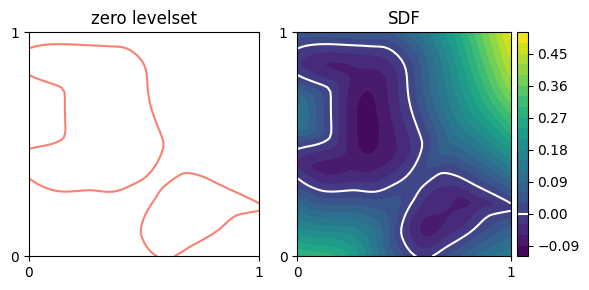

In [10]:
plot2d(lambda x: model(jnp.array([0.4, x[0], x[1]])), ngrid=50)

In [11]:
def normalize(v):
    return v / jnp.linalg.norm(v)

def triangle_normal(triangle):
    v1, v2, v3 = triangle
    return normalize(jnp.cross(v2 - v1, v3 - v1))

def vertex_normals(vertices, faces):
    """Computes vertex normals by uniform averaging of triangle normals."""
    triangles = vertices[faces]
    trinormals = jax.vmap(triangle_normal)(triangles)
    normals = jax.ops.segment_sum(trinormals, faces[:,0])
    normals += jax.ops.segment_sum(trinormals, faces[:,1])
    normals += jax.ops.segment_sum(trinormals, faces[:,2])
    normals = jax.vmap(normalize)(normals)
    return normals


loss, model = fit(xs, normals=vertex_normals(vertices, faces), steps=300, cb_every=10, batch_size=1024, act=softplus, hidden=512, lam=0.1, radius_init=0.5, key=key)
fig = plot3d(model, x_lims=(-0.1, 1.1), ngrid=50)
fig

  0%|          | 0/300 [00:00<?, ?it/s]

[0] loss: 1.53273463
[10] loss: 0.68843746
[20] loss: 0.57170862
[30] loss: 0.44854495
[40] loss: 0.43226054
[50] loss: 0.34825271
[60] loss: 0.31256279
[70] loss: 0.27232513
[80] loss: 0.24326849
[90] loss: 0.23980071
[100] loss: 0.22358216
[110] loss: 0.22154194
[120] loss: 0.21021993
[130] loss: 0.17288724
[140] loss: 0.19669941
[150] loss: 0.16829030
[160] loss: 0.18228680
[170] loss: 0.17204936
[180] loss: 0.15710081
[190] loss: 0.17726296
[200] loss: 0.21357718
[210] loss: 0.16962387
[220] loss: 0.16663608
[230] loss: 0.20824490
[240] loss: 0.16084065
[250] loss: 0.14475238
[260] loss: 0.14707944
[270] loss: 0.14295532
[280] loss: 0.15331164
[290] loss: 0.16347881
[299] loss: 0.15652046
